In [4]:
import pandas as pd
import h3
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt

# displays figures directly inline in the Jupyter notebook
%matplotlib inline

In [5]:
df = pd.read_csv("trips_sample.csv",parse_dates=["timestamp"])
print(df.head())

            timestamp  origin_lat  origin_lon  dest_lat  dest_lon  price_usd  \
0 2025-06-01 08:15:00      37.775    -122.418    37.789  -122.401      14.50   
1 2025-06-01 08:20:00      37.776    -122.419    37.788  -122.400      15.00   
2 2025-06-01 08:25:00      37.774    -122.417    37.790  -122.402      13.75   
3 2025-06-01 09:00:00      37.780    -122.420    37.791  -122.405      12.50   
4 2025-06-01 09:15:00      37.779    -122.419    37.792  -122.404      11.75   

   trips  
0      1  
1      1  
2      1  
3      2  
4      3  


In [6]:
# import h3
#lat, lng = 37.769377, -122.388903
#resolution = 7
#h3.latlng_to_cell(lat, lng, resolution)

# sample point
lat = df.loc[0,"origin_lat"]
lon = df.loc[0,"origin_lon"]
H3_RES = 7 

#print(lat)
#print(lon)

In [7]:
# gives hex ID for specific lat and lon and given resolution
h3_index = h3.latlng_to_cell(lat,lon,H3_RES)
center_lat, center_lon = h3.cell_to_latlng(h3_index)
print(h3_index)
print(center_lat, center_lon)

872830828ffffff
37.773515097238146 -122.41827103692466


In [8]:
# gives coordinates of boundary of H3 hexagon
boundary = h3.cell_to_boundary(h3_index)
boundary_lonlat = [(lon, lat) for lat, lon in boundary]

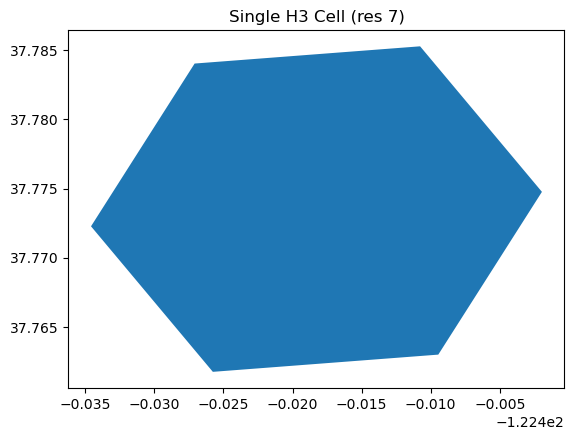

In [9]:
# takes a list of lon and lat points and converts into a Polygon
polygon = Polygon(boundary_lonlat)

gdf_test = gpd.GeoDataFrame(index=[0], geometry=[polygon])
gdf_test.plot()
plt.title(f"Single H3 Cell (res {H3_RES})")
plt.show()

In [10]:
# creates new column in dataframe containing H3 index for each row's lat and lon
df['h3_origin'] = df.apply(
    lambda row: h3.latlng_to_cell(row['origin_lat'], row['origin_lon'], H3_RES),
    axis= 1 
)
display(df.head())

# groups each h3 cell by their respective trips and prices
agg = df.groupby('h3_origin').agg(
    trips_sum=('trips', 'sum'),
    price_mean=('price_usd', 'mean')
).reset_index()
display(agg.head())

,timestamp,origin_lat,origin_lon,dest_lat,dest_lon,price_usd,trips,h3_origin
0,2025-06-01 08:15:00,37.775,-122.418,37.789,-122.401,14.50,1,872830828ffffff
1,2025-06-01 08:20:00,37.776,-122.419,37.788,-122.400,15.00,1,872830828ffffff
2,2025-06-01 08:25:00,37.774,-122.417,37.790,-122.402,13.75,1,872830828ffffff
3,2025-06-01 09:00:00,37.780,-122.420,37.791,-122.405,12.50,2,872830828ffffff
4,2025-06-01 09:15:00,37.779,-122.419,37.792,-122.404,11.75,3,872830828ffffff


,h3_origin,trips_sum,price_mean
0,872830828ffffff,79,16.05


 GeoJSON saved: h3_cells.geojson


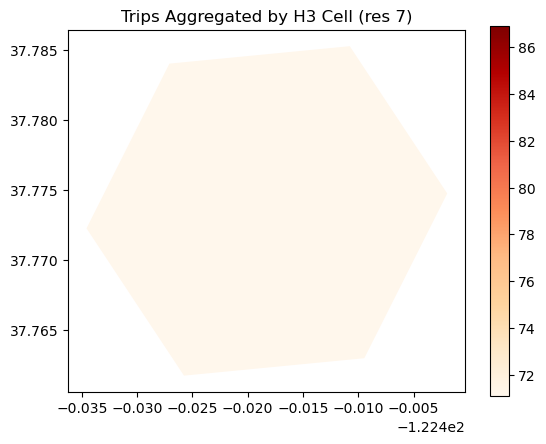

In [11]:
# convert H3 index to shapely polygon
def h3_to_polygon(h3_index):
    boundary = h3.cell_to_boundary(h3_index)
    boundary_lonlat = [(lon, lat) for lat, lon in boundary]
    return Polygon(boundary_lonlat)

agg['geometry'] = agg['h3_origin'].apply(h3_to_polygon)

# FIX: pass column name, not Series
gdf = gpd.GeoDataFrame(agg, geometry="geometry")

# set CRS to WGS84 (lat/lon)
gdf.set_crs(epsg=4326, inplace=True)

gdf.to_file("h3_cells.geojson", driver='GeoJSON')
print(" GeoJSON saved: h3_cells.geojson")

gdf.plot(column='trips_sum', cmap='OrRd', legend=True)
plt.title(f"Trips Aggregated by H3 Cell (res {H3_RES})")
plt.show()

In [12]:
gdf = gpd.read_file("h3_cells.geojson")  
# How many rows? Print
print("Rows in dataset:", len(gdf))

# Randomly mark 20% of H3 cells as treated
np.random.seed(50)  # Fill in seed
random_values = np.random.rand(len(gdf))
gdf['treated'] = random_values < 0.2  # sets treated column (out of all cells, 20% will be randomly chosen to be treated)

# How many treated? Print
print("Treated cells:", gdf['treated'].sum())

# Increase price by 10% in treated cells
gdf['price_mean_new'] = gdf['price_mean']  # new price column
gdf.loc[gdf['treated'], 'price_mean_new'] = gdf.loc[gdf['treated'], 'price_mean_new'] * 1.10
# for all rows where gdf treated is True, increase the value in the price_mean column by 10%. 

Rows in dataset: 1


NameError: name 'np' is not defined

   origin_lat  origin_lon  trips  price_usd
0   37.693635 -122.471273      2  16.115149
1   37.837679 -122.455313      3  26.396821
2   37.782998 -122.379091      7  18.279081
3   37.749665 -122.481999      0  15.075433
4   37.639005 -122.376070      0  20.346484
Simulated trips: 5000
Unique H3 cells: 113
Aggregated rows: 113
         h3_origin  trips_sum  price_mean  \
0  872830800ffffff         32   21.508059   
1  872830801ffffff        116   19.332146   
2  872830803ffffff         52   19.450701   
3  872830804ffffff         13   26.065155   
4  872830805ffffff        160   20.855945   

                                            geometry  
0  POLYGON ((-122.34 37.78, -122.33 37.791, -122....  
1  POLYGON ((-122.36 37.789, -122.35 37.801, -122...  
2  POLYGON ((-122.34 37.802, -122.33 37.814, -122...  
3  POLYGON ((-122.34 37.757, -122.33 37.769, -122...  
4  POLYGON ((-122.36 37.767, -122.35 37.778, -122...  
✅ GeoJSON saved: h3_cells.geojson


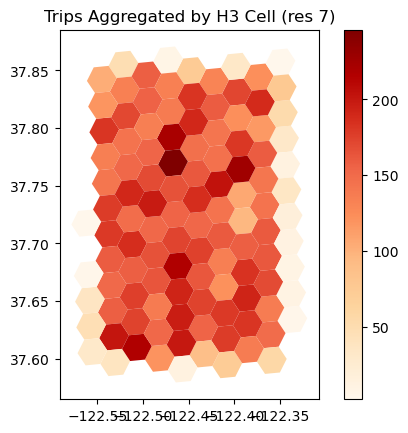

In [19]:
import pandas as pd
import numpy as np

np.random.seed(42)  # reproducible

n = 5000  # number of trips

# Simulate trips spread across a bounding box (e.g., San Francisco)
df = pd.DataFrame({
    'origin_lat': np.random.uniform(37.6, 37.85, size=n),       # latitudes in SF
    'origin_lon': np.random.uniform(-122.55, -122.35, size=n),  # longitudes in SF
    'trips': np.random.poisson(3, size=n),                      # trips per event
    'price_usd': np.random.uniform(8, 30, size=n)               # trip price in USD
})

print(df.head())
print(f"Simulated trips: {len(df)}")

H3_RES = 7  # adjust resolution as desired

# Add H3 cell index
df['h3_origin'] = df.apply(
    lambda row: h3.latlng_to_cell(row['origin_lat'], row['origin_lon'], H3_RES),
    axis=1
)

print(f"Unique H3 cells: {df['h3_origin'].nunique()}")

# Aggregate trips & prices per H3 cell
agg = df.groupby('h3_origin').agg(
    trips_sum=('trips', 'sum'),
    price_mean=('price_usd', 'mean')
).reset_index()

print(f"Aggregated rows: {len(agg)}")

# Convert H3 cell index to polygons
def h3_to_polygon(h3_index):
    boundary = h3.cell_to_boundary(h3_index)
    boundary_lonlat = [(lon, lat) for lat, lon in boundary]
    return Polygon(boundary_lonlat)

agg['geometry'] = agg['h3_origin'].apply(h3_to_polygon)

# Create GeoDataFrame properly
gdf = gpd.GeoDataFrame(agg, geometry="geometry")
gdf.set_crs(epsg=4326, inplace=True)

print(gdf.head())

# Save to GeoJSON
gdf.to_file("h3_cells.geojson", driver="GeoJSON")
print("✅ GeoJSON saved: h3_cells.geojson")

# Quick map
gdf.plot(column='trips_sum', cmap='OrRd', legend=True)
plt.title(f"Trips Aggregated by H3 Cell (res {H3_RES})")
plt.show()